In [1]:
# Import all the libraries
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats
# pd.options.mode.chained_assignment = None  # default='warn', Mutes warnings when copying a slice from a DataFrame.
# pd.set_option('display.max_columns', None)
import glob
import datetime
import os
import json
from io import StringIO
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
%matplotlib inline

### Sampling and loading the data
For this exploratory analysis we used the Spark cluster to randomly sample the data and retrieve the metadata for the items that appear in our review sample.

In [2]:
# Paths to the data and metadata folders.
DATA_FOLDER = 'data/'
META_FOLDER = DATA_FOLDER + 'meta/'

In [3]:
# Load one data file
def load_one_file(path):
    with open(path) as f:
        return [json.loads(line) for line in f]

# Load one metadata file. The rows aren't proper JSON
# but they can be parsed using python's eval function
# as per the dataset's web page.
def load_one_meta_file(path):
    with open(path) as f:
        return [eval(line) for line in f]

# The sample we extracted is still too large, so we'll only use the first 100 files
data_files = glob.glob(DATA_FOLDER + 'part-000*')
data = sum(map(load_one_file, data_files), [])

# The meta folder contains metadata for all the items we were interested in.
meta_files = glob.glob(META_FOLDER + '*')
meta = sum(map(load_one_meta_file, meta_files), [])

# Create the two dataframes
df = pd.DataFrame(data)
meta_df = pd.DataFrame(meta)

In [4]:
# Join the dataframes. Since our analysis relies on the metadata for a good part
# we have to remove any reviews for which metadata is not available.
joined = pd.merge(df, meta_df, how='inner')

# Parse the review time as a DateTime and add a review month column
joined['reviewTime'] = pd.to_datetime(joined.unixReviewTime, unit='s')
joined['reviewMonth'] = joined.reviewTime.map(lambda t: t.month)
joined['reviewYear'] = joined.reviewTime.map(lambda t: t.year)

# We don't want any reviews for which the price is either NaN or 0
# or for which the category is NaN
joined = joined.dropna(axis=0, subset=['categories', 'price', 'reviewText'])
joined = joined[joined.price != 0 & (len(joined.reviewText) > 0)]


### Adding features
#### Sentiment scores
We used [VADER](https://github.com/cjhutto/vaderSentiment), a sentiment score analyzer tuned for messages that tipically appear on social media to give each review text a series of sentiment scores.

In [5]:
analyzer = SentimentIntensityAnalyzer()
print(joined.iloc[4]['reviewText'])
analyzer.polarity_scores(joined.iloc[4]['reviewText'])

It is really good! But it was hard to push out all the air bubbles. But that is not a big problem


{'compound': 0.6534, 'neg': 0.056, 'neu': 0.716, 'pos': 0.228}

In [6]:
# Add two sentiment score columns to the dataframe
comp_score = joined.reviewText.apply(lambda t: analyzer.polarity_scores(t))
joined['compound_score'] = comp_score.apply(lambda s: s['compound'])
joined['positive_score'] = comp_score.apply(lambda s: s['pos'])
joined['negative_score'] = comp_score.apply(lambda s: s['neg'])
joined['neutral_score'] = comp_score.apply(lambda s: s['neu'])

#### Main category
Each item in the dataset has a `categories` field which, when not absent, is an array of arrays of strings. Each item can belong to an arbitrary number of categories some of which are subcategories of a larger category. We will first flatten these arrays of arrays in order to make subsequent processing easier.

In [7]:
# Flatten the categories
joined['categories_flat'] = joined.categories.apply(lambda a: [i for sa in a for i in sa])
# Remove entries with no categories
joined = joined[[(c and bool(c[0])) for c in joined.categories_flat]]

In order to be able to plot aggregate values for each category we need to pick a list of categories that we will use as the main category of the product. One possible choice is the one that was used by the maintainer of the dataset to generate category-specific review files but we found that some of the products did not belong to any of the categories in that list and so we had to add some of our own.

In [8]:
categories_dict = None
with open('categories_dict.json') as f:
    categories_dict = json.load(f)

In [9]:
# Function that returns an item's main category according
# to the above list, or NaN if none of its categories appear in the list.
def get_main_category(categories):
    for c in categories:
        if c in categories_dict:
            return categories_dict[c]

    return np.nan

# Derive each product's main category
joined['main_category'] = joined.categories_flat.apply(lambda a: get_main_category(a))
# Remove items for which there is no category
joined = joined.dropna(axis=0, subset=['main_category'])

In [10]:
# Final dataframe
joined.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,...,salesRank,title,reviewMonth,reviewYear,compound_score,positive_score,negative_score,neutral_score,categories_flat,main_category
2,B00E7OIOVC,"[0, 0]",5.0,Great!,2014-07-03,A0001528BGUBOEVR6T5U,igozingo,Five Stars,1404345600,niceEshop,...,{'Kitchen & Dining': 63021},niceEshop(TM) Small Stainless Steel Funnel For...,7,2014,0.6588,1.000,0.000,0.000,"[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen
3,B00EXOZ9W8,"[0, 0]",5.0,"My man was more then happy with it, looking fo...",2014-07-02,A00030342K9JCQO8Q7C3L,Joseph Dvorak,Five Stars,1404259200,NaN,...,{'Kitchen & Dining': 56153},BELLA 14025 Programmable Slow Cooker with Lock...,7,2014,0.7893,0.349,0.000,0.651,"[Home & Kitchen, Kitchen & Dining, Small Appli...",Home & Kitchen
4,1477473939,"[0, 0]",4.0,Reading this seriers was a amazing. It was ver...,2013-01-26,A000443821AD43TOGKNGZ,Uluwehi,Really enjoyed it!,1359158400,NaN,...,{'Books': 1011147},Making You Mine: The Moreno Brothers,1,2013,0.9199,0.353,0.000,0.647,[Books],Books
5,1477473939,"[0, 0]",4.0,"I haven't read any of this series before, but ...",2013-04-09,A1BAWRQQMC7L72,Roswellfan410,Really liked it,1365465600,NaN,...,{'Books': 1011147},Making You Mine: The Moreno Brothers,4,2013,0.9548,0.411,0.000,0.589,[Books],Books
6,B0092QSQ3Q,"[0, 0]",5.0,It is really good! But it was hard to push out...,2012-11-03,A00044782UB564I4SGA0X,Johan98,Really good!,1351900800,NaN,...,{'Cell Phones & Accessories': 4377},Skinomi&reg; TechSkin - Apple iPhone 5 Screen ...,11,2012,0.6534,0.228,0.056,0.716,"[Cell Phones & Accessories, Accessories, Scree...",Electronics


In [11]:
# See how many reviews are left
print('Remaining reviews: {}'.format(joined.shape[0]))

Remaining reviews: 125958


In [16]:
# Arbitrarily chosen
price_bins = [
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    200,
    500,
    1000
]

In [17]:
joined.reset_index(drop = True, inplace = True)

# from nltk.tokenize import TweetTokenizer

reviews = []
review_len = []
# tknzr = TweetTokenizer()
# for i in range(joined.shape[0]):
#     reviews.append(tknzr.tokenize(joined.iloc[i]['reviewText']))
    
    
    
    
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
for i in range(joined.shape[0]):
    words = tokenizer.tokenize(joined.iloc[i]['reviewText'])
    reviews.append(words)
    review_len.append(len(words))
joined.loc[:,'tokenized_text'] = pd.Series(reviews)
joined.loc[:, 'word_count'] = pd.Series(review_len)


In [18]:
# Look at each category, sentiment score per rating
def plot_each_category(groupby, column_to_average):

    categories = joined.main_category.unique()
    for c in categories:
        x = joined[joined['main_category'] == c]
        print(c)
        if groupby is 'price':
            (x.groupby(pd.cut(x.price, price_bins))[column_to_average].mean()).plot(kind = 'bar')
            
        else:
            (x.groupby(groupby)[column_to_average].mean()).plot(kind = 'bar')

        plt.show()

In [19]:
joined.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,...,reviewMonth,reviewYear,compound_score,positive_score,negative_score,neutral_score,categories_flat,main_category,tokenized_text,word_count
0,B00E7OIOVC,"[0, 0]",5.0,Great!,2014-07-03,A0001528BGUBOEVR6T5U,igozingo,Five Stars,1404345600,niceEshop,...,7,2014,0.6588,1.000,0.000,0.000,"[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen,[Great],1
1,B00EXOZ9W8,"[0, 0]",5.0,"My man was more then happy with it, looking fo...",2014-07-02,A00030342K9JCQO8Q7C3L,Joseph Dvorak,Five Stars,1404259200,NaN,...,7,2014,0.7893,0.349,0.000,0.651,"[Home & Kitchen, Kitchen & Dining, Small Appli...",Home & Kitchen,"[My, man, was, more, then, happy, with, it, lo...",14
2,1477473939,"[0, 0]",4.0,Reading this seriers was a amazing. It was ver...,2013-01-26,A000443821AD43TOGKNGZ,Uluwehi,Really enjoyed it!,1359158400,NaN,...,1,2013,0.9199,0.353,0.000,0.647,[Books],Books,"[Reading, this, seriers, was, a, amazing, It, ...",31
3,1477473939,"[0, 0]",4.0,"I haven't read any of this series before, but ...",2013-04-09,A1BAWRQQMC7L72,Roswellfan410,Really liked it,1365465600,NaN,...,4,2013,0.9548,0.411,0.000,0.589,[Books],Books,"[I, haven, t, read, any, of, this, series, bef...",35
4,B0092QSQ3Q,"[0, 0]",5.0,It is really good! But it was hard to push out...,2012-11-03,A00044782UB564I4SGA0X,Johan98,Really good!,1351900800,NaN,...,11,2012,0.6534,0.228,0.056,0.716,"[Cell Phones & Accessories, Accessories, Scree...",Electronics,"[It, is, really, good, But, it, was, hard, to,...",22


In [25]:
joined.main_category.unique()


array(['Home & Kitchen', 'Books', 'Electronics', 'Food',
       'Health & Personal Care', 'Movies & TV', 'Office Products', 'Music',
       'Video Games', 'Clothing, Shoes & Jewelry', 'Beauty',
       'Musical Instruments', 'Tools & Home Improvement', 'Automotive',
       'Gift Cards', 'Patio, Lawn & Garden', 'Arts, Crafts & Sewing',
       'Sports & Outdoors', 'Amazon Coins', 'Toys & Games', 'Baby', 'Pets',
       'Amazon Instant Video', 'Industrial & Scientific',
       'Apps for Android', 'Kindle Store', 'Computing',
       'Magazine Subscriptions'], dtype=object)

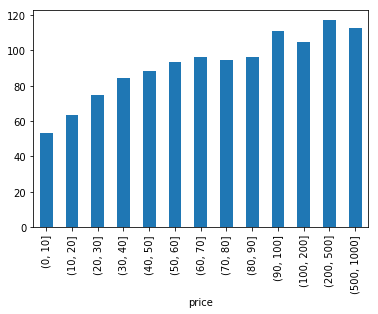

In [32]:
x = joined[joined['main_category'] == 'Electronics']
(x.groupby(pd.cut(x.price, price_bins))['word_count'].mean()).plot(kind = 'bar')

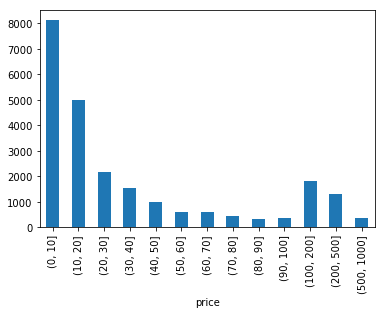

In [33]:
(x.groupby(pd.cut(x.price, price_bins)).size()).plot(kind = 'bar')

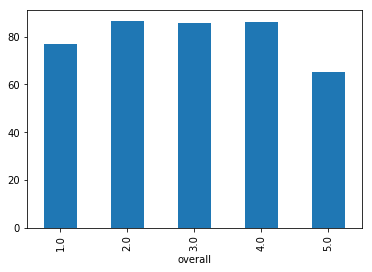

In [22]:
(x.groupby('overall')['word_count'].mean()).plot(kind = 'bar')

### Error bars
When plotting aggregate statistics for a group, such as the mean score, we need to include error bars in the plot. We used bootstrap resampling to derive confidence intervals for those statistics since the underlying distribution of the data is unknown to us in general.

In [ ]:
def bootstrap_estimate(data, func):
    """Calculate a bootstrap estimate of a certain function of a sequence
    This function draws a random sample with replacement from a list and
    uses func to calculate a statistic over that sample.
    Since the sample is drawn with replacement each element of the list
    may appear multiple times or not appear at all in the sample.
    """
    n = len(data)
    
    # Generate n random indices with replacement
    indices = np.random.randint(n, size=n)
    
    # Sample the data
    sample = data.iloc[indices]

    # Compute the statistic
    return func(sample)

def confidence_interval(data, count, func, confidence=0.95):
    """Return a statistic and its confidence interval of a sequence using bootstrap resampling.
    Computes the statistic over count bootstrap samples drawn from the data, then computes the 
    lower and uppper bounds of the confidence interval.
    """
    estimates = [bootstrap_estimate(data, func) for _ in range(count)]
    
    # Debug: verify that the estimates have a normal distribution
    # plt.hist(estimates, bins=50)
    
    # Calculate the confidence interval bounds assuming a normal distribution in
    # the estimates
    m, se = np.mean(estimates), np.std(estimates)
    lower, upper = scipy.stats.norm.interval(confidence, loc=m, scale=se)
    
    return m, lower, upper

def plot_groupby_error_bars(grouped, count, func, ax, confidence=0.95):
    """Plot a bar plot showing the result of a statistic applied to the groups
    of a groupby object and use count bootstrap samples to compute confidence intervals
    """
    out = grouped.agg(lambda a: confidence_interval(a, count, func, confidence))
    means = out.apply(lambda x: x[0])
    mins = out.apply(lambda x: x[1] - x[0])
    maxs = out.apply(lambda x: x[2] - x[0])

    errs = np.c_[mins, maxs].T
    means.plot(kind='bar', ax=ax, yerr=errs, ecolor='r')

In [ ]:
# Example: 95% confidence interval of the mean of the review scores with
# 1000 bootstrap samples. 
confidence_interval(joined.overall, 1000, np.mean)

### Feature analysis
We can now start to have a look at the distribution of the various features. First of all: overall score

In [ ]:
# Overall distribution
joined.overall.value_counts().plot(kind='pie', title='Distribution of review scores')

In [ ]:
# Distribution with respect to price
_, ax1 = plt.subplots(1, 1, figsize=(16,5))
bins = np.linspace(0, 1000, 12)
gb = joined.groupby('overall')
series = np.array([np.histogram(gb.get_group(i).price.values, bins=bins)[0] for i in range(1, 6)])

series = series / series.sum(axis=0)
histbins = bins[:-1] + np.ediff1d(bins) / 2
bottom = np.zeros(series.shape[1])

for i in range(series.shape[0]):
    ax1.bar(histbins, series[i], width=50, bottom=bottom)
    bottom += series[i]

We can see that more than half of the reviews gave five stars to the product independently of the price. The low proportion of 1 and 2 star reviews suggests that customers are very likely to be satisfied with the product they purchased. For this reason it might be interesting to also look at the set of reviews that didn't give the product 5/5 stars.


In [ ]:
no_5_star = joined[joined.overall != 5]

Let's now consider the number of reviews by month of the year.

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
no_5_star.reviewMonth.value_counts().plot(ax=ax2, kind='bar', title='Review distribution by month (no 5 star reviews)')
joined.reviewMonth.value_counts().plot(ax=ax1, kind='bar', title='Review distribution by month')

The number of reviews seems to be highest during winter and spring and lower during autumn, with January being the month with the highest number of reviews. The biggest shopping time in the year is during the christmas holidays and we imagine that reviews are written the next month after the product has been used for some time.

We can now start looking at the prices of the items. We can define some price bins that will allow us to group the items in price tiers.

In [ ]:
# Arbitrarily chosen
price_bins = [
    0,
    10,
    20,
    30,
    40,
    50,
    60,
    70,
    80,
    90,
    100,
    200,
    500,
    1000
]

In [ ]:
# Group the items by price tier
group_by_price_tier = joined.groupby(pd.cut(joined.price, price_bins))
no5_group_by_price_tier = no_5_star.groupby(pd.cut(no_5_star.price, price_bins))

First of all we can plot the distribution of the prices of reviewed items.

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
ax1.set_title('Review distribution by price')
ax2.set_title('Review distribution by price (no 5 star reviews)')
joined.price.hist(bins=50, ax=ax1)
no_5_star.price.hist(bins=50, ax=ax2)

The distribution seems to be heavy tailed, with very cheap items making up the majority of the reviews. We can verify if this distribution follows a power law by plotting it on a log-log scale.

In [ ]:
# We need to make logarithmic bins ourselves.
log_bins = np.logspace(np.log10(min(joined.price)), np.log10(max(joined.price)), 50)
no5_log_bins = np.logspace(np.log10(min(joined.price)), np.log10(max(joined.price)), 50)

fig = plt.figure(figsize=(16, 5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

ax1.set_xscale('log')
ax1.set_title('Review distribution by price')
ax2.set_xscale('log')
ax2.set_title('Review distribution by price (no 5 star reviews)')

joined.price.hist(ax=ax1, log=True, bins=log_bins)
no_5_star.price.hist(ax=ax2, log=True, bins=no5_log_bins)

The distribution doesn't follow a linear relationship on a log-log plot so the distribution is not a power law.

Now let's see the distribution according to the price tiers we defined above.

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

ax1.set_title('Review distribution by price bracket')
ax2.set_title('Review distribution by price bracket (no 5 star reviews)')

group_by_price_tier.size().plot(kind='bar', ax=ax1)
no5_group_by_price_tier.size().plot(kind='bar', ax=ax2)

One of the hypotheses we want to verify is whether the price of an item correlates with its review score, more specifically whether items belonging to a higher price tier are more likely to get better reviews. We can verify that by computing the mean review score for each price tier and displaying that on a bar plot.

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,5))

ax1.set_title('Average review score by price bracket')
ax2.set_title('Average review score by price bracket (no 5 star reviews)')

plot_groupby_error_bars(group_by_price_tier.overall, 1000, np.mean, ax=ax1)
plot_groupby_error_bars(no5_group_by_price_tier.overall, 1000, np.mean, ax=ax2)

We can also try plotting the median of the scores. Since the values are discrete in the [1, 5] interval and more than half of the reviews are 5 we expect the medians to always be 5 in the plot where 5-star reviews are included.

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,5))

ax1.set_title('Median review score by price bracket')
ax2.set_title('Median review score by price bracket (no 5 star reviews)')

plot_groupby_error_bars(group_by_price_tier.overall, 1000, np.median, ax=ax1)
plot_groupby_error_bars(no5_group_by_price_tier.overall, 1000, np.median, ax=ax2)

There seems to be no correlation between an item's price tier and its mean and median review score.

We can also verify whether the month during which a review was written correlates with its score. The presence of such a correlation could indicate that buyers are more likely to give a better review in certain periods of the year than others.

In [ ]:
# Group data by the month in which the review was written.
group_by_month = joined.groupby('reviewMonth')
overall_month = group_by_month.overall

no5_group_by_month = no_5_star.groupby('reviewMonth')
no5_overall_month = no5_group_by_month.overall

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,5))

ax1.set_title('Average review score by month')
ax2.set_title('Average review score by month (no 5 star reviews)')

plot_groupby_error_bars(overall_month, 1000, np.mean, ax1)
plot_groupby_error_bars(no5_overall_month, 1000, np.mean, ax2)

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,5))

ax1.set_title('Median review score by month')
ax2.set_title('Median review score by month (no 5 star reviews)')

plot_groupby_error_bars(overall_month, 1000, np.median, ax1)
plot_groupby_error_bars(no5_overall_month, 1000, np.median, ax2)

Again, we can see that the correlation we hypothesized does not exist in the data. The review scores seem to be independent of the month in which they were written.

Let's now look at the items grouped by their category

In [ ]:
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))
ax1.set_title('Review distribution by main category')
ax1.set_title('Review distribution by main category (no 5 star reviews)')
joined.main_category.value_counts().plot(kind='bar', ax=ax1)
no_5_star.main_category.value_counts().plot(kind='bar', ax=ax2)

In [ ]:
pd.DataFrame({
    'All reviews': joined.main_category.value_counts(),
    'No 5 star reviews': no_5_star.main_category.value_counts()
}).sort_values('All reviews', ascending=False)

The most popular categories by a large margin seem to be books and electronics. The least popular categories have very few reviews in our sample so the results we get from them might not be very relevant.

In [ ]:
_, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15,5))
by_category = joined.groupby('main_category')
no5_by_category = no_5_star.groupby('main_category')

ax1.set_title('Mean review score by category')
ax2.set_title('Mean review score by category (no 5 star reviews)')

plot_groupby_error_bars(by_category.overall, 1000, np.mean, ax1)
plot_groupby_error_bars(no5_by_category.overall, 1000, np.mean, ax2)

We can see from here that products belonging to certain categories indeed tend to receive better reviews on average.

We can also look at the relationship between the overall rating given in a review and the overall sentiment score of the description. We expect negative reviews to have a sentiment score closer to -1 and vice versa.

In [ ]:
by_overall = joined.groupby('overall')

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.set_title('Mean compound sentiment score')
ax2.set_title('Median compound sentiment score')
plot_groupby_error_bars(by_overall.compound_score, 1000, np.mean, ax1)
plot_groupby_error_bars(by_overall.compound_score, 1000, np.median, ax2)

Our expectations were correct: negative reviews indeed have a lower sentiment score, but even the 1 star reviews do not seem to have a strongly negative connotation. Perhaps overly rude or angry reviews are removed by Amazon's staff.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.set_title('Mean positive sentiment score')
ax2.set_title('Median positive sentiment score')
plot_groupby_error_bars(by_overall.positive_score, 1000, np.mean, ax1)
plot_groupby_error_bars(by_overall.positive_score, 1000, np.median, ax2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.set_title('Mean neutral sentiment score')
ax2.set_title('Median neutral sentiment score')
plot_groupby_error_bars(by_overall.neutral_score, 1000, np.mean, ax1)
plot_groupby_error_bars(by_overall.neutral_score, 1000, np.median, ax2)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.set_title('Mean negative sentiment score')
ax2.set_title('Median negative sentiment score')
plot_groupby_error_bars(by_overall.negative_score, 1000, np.mean, ax1)
plot_groupby_error_bars(by_overall.negative_score, 1000, np.median, ax2)

The negative, positive and neutral sentiment scores confirm what we saw by observing the compound score.

We can also verify whether a different price translates to a higher sentiment score.

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.set_title('Mean compound sentiment score')
ax2.set_title('Median compound sentiment score')
plot_groupby_error_bars(group_by_price_tier.compound_score, 1000, np.mean, ax1)
plot_groupby_error_bars(group_by_price_tier.compound_score, 1000, np.median, ax2)

In [ ]:
joined.groupby(['main_category'])

In [ ]:


# Create dataframe with needed information
product_reviews = pd.DataFrame({'productID': df.asin,
                                'rating': df.overall,
                                'time': pd.to_datetime(df.reviewTime, format='%m %d, %Y')
                                })
product_reviews['month'] = product_reviews.time.map(lambda t: t.month)
product_reviews.set_index('productID', drop=True, inplace=True)
product_reviews.head()

In [ ]:
# Create a product by month table to spot periodicity
# Each entry is the mean of ratings the product gets within certain month
# Nans are filled with 0
product_month = product_reviews.pivot_table(values='rating',
                                            index=product_reviews.index,
                                            columns='month',
                                            fill_value=0)

# Select products with number of reviews larger than the threshold
review_count = product_reviews.index.value_counts()
product_month = product_month.loc[review_count>N_REVIEW_THRESHOLD]

product_month.head()

## ToDo: Spot/measure the periodicity (automatically)

In [34]:
joined.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,...,reviewMonth,reviewYear,compound_score,positive_score,negative_score,neutral_score,categories_flat,main_category,tokenized_text,word_count
0,B00E7OIOVC,"[0, 0]",5.0,Great!,2014-07-03,A0001528BGUBOEVR6T5U,igozingo,Five Stars,1404345600,niceEshop,...,7,2014,0.6588,1.000,0.000,0.000,"[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen,[Great],1
1,B00EXOZ9W8,"[0, 0]",5.0,"My man was more then happy with it, looking fo...",2014-07-02,A00030342K9JCQO8Q7C3L,Joseph Dvorak,Five Stars,1404259200,NaN,...,7,2014,0.7893,0.349,0.000,0.651,"[Home & Kitchen, Kitchen & Dining, Small Appli...",Home & Kitchen,"[My, man, was, more, then, happy, with, it, lo...",14
2,1477473939,"[0, 0]",4.0,Reading this seriers was a amazing. It was ver...,2013-01-26,A000443821AD43TOGKNGZ,Uluwehi,Really enjoyed it!,1359158400,NaN,...,1,2013,0.9199,0.353,0.000,0.647,[Books],Books,"[Reading, this, seriers, was, a, amazing, It, ...",31
3,1477473939,"[0, 0]",4.0,"I haven't read any of this series before, but ...",2013-04-09,A1BAWRQQMC7L72,Roswellfan410,Really liked it,1365465600,NaN,...,4,2013,0.9548,0.411,0.000,0.589,[Books],Books,"[I, haven, t, read, any, of, this, series, bef...",35
4,B0092QSQ3Q,"[0, 0]",5.0,It is really good! But it was hard to push out...,2012-11-03,A00044782UB564I4SGA0X,Johan98,Really good!,1351900800,NaN,...,11,2012,0.6534,0.228,0.056,0.716,"[Cell Phones & Accessories, Accessories, Scree...",Electronics,"[It, is, really, good, But, it, was, hard, to,...",22


In [36]:
x = 'unbiased review here'
y = 'unbiased review' in x

In [58]:
mask = joined['reviewText'].map(lambda x: ('unbiased review' in x) or ('honest review' in x) or ('in exchange for' in x) or ('disclaimer' in x))
incentivized = joined[mask]
non_incentivized = joined[~mask]

In [59]:
joined.shape

(125958, 27)

In [60]:
incentivized.shape

(348, 27)

In [63]:
incentivized['overall'].mean()

4.3017241379310347

In [64]:
non_incentivized['overall'].mean()

4.1887349733301491

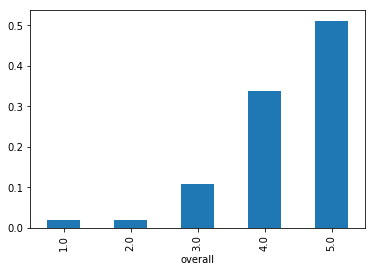

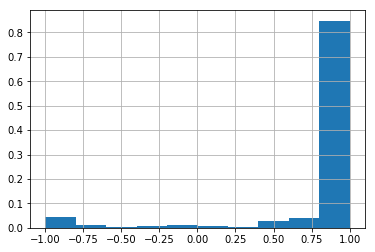

In [83]:
(incentivized.groupby('overall').size()/incentivized.shape[0]).plot(kind = 'bar')
plt.show()
incentivized['compound_score'].hist(weights = [1/incentivized.shape[0]]*incentivized.shape[0])
plt.show()

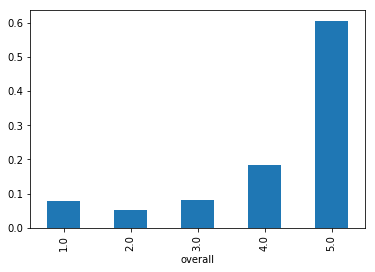

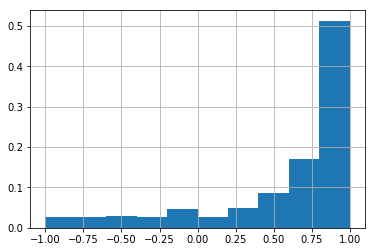

In [85]:
(non_incentivized.groupby('overall').size()/non_incentivized.shape[0]).plot(kind = 'bar')
plt.show()
non_incentivized['compound_score'].hist(weights = [1/non_incentivized.shape[0]]*non_incentivized.shape[0])

In [70]:
joined.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime,brand,...,reviewMonth,reviewYear,compound_score,positive_score,negative_score,neutral_score,categories_flat,main_category,tokenized_text,word_count
0,B00E7OIOVC,"[0, 0]",5.0,Great!,2014-07-03,A0001528BGUBOEVR6T5U,igozingo,Five Stars,1404345600,niceEshop,...,7,2014,0.6588,1.000,0.000,0.000,"[Home & Kitchen, Kitchen & Dining, Kitchen Ute...",Home & Kitchen,[Great],1
1,B00EXOZ9W8,"[0, 0]",5.0,"My man was more then happy with it, looking fo...",2014-07-02,A00030342K9JCQO8Q7C3L,Joseph Dvorak,Five Stars,1404259200,NaN,...,7,2014,0.7893,0.349,0.000,0.651,"[Home & Kitchen, Kitchen & Dining, Small Appli...",Home & Kitchen,"[My, man, was, more, then, happy, with, it, lo...",14
2,1477473939,"[0, 0]",4.0,Reading this seriers was a amazing. It was ver...,2013-01-26,A000443821AD43TOGKNGZ,Uluwehi,Really enjoyed it!,1359158400,NaN,...,1,2013,0.9199,0.353,0.000,0.647,[Books],Books,"[Reading, this, seriers, was, a, amazing, It, ...",31
3,1477473939,"[0, 0]",4.0,"I haven't read any of this series before, but ...",2013-04-09,A1BAWRQQMC7L72,Roswellfan410,Really liked it,1365465600,NaN,...,4,2013,0.9548,0.411,0.000,0.589,[Books],Books,"[I, haven, t, read, any, of, this, series, bef...",35
4,B0092QSQ3Q,"[0, 0]",5.0,It is really good! But it was hard to push out...,2012-11-03,A00044782UB564I4SGA0X,Johan98,Really good!,1351900800,NaN,...,11,2012,0.6534,0.228,0.056,0.716,"[Cell Phones & Accessories, Accessories, Scree...",Electronics,"[It, is, really, good, But, it, was, hard, to,...",22
